In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# TODO: solve eloreta >1 recontructed noise level

from bsi_zoo.config import get_leadfield_path
from bsi_zoo.data_generator import get_data

In [3]:
# these are the SNR values we want to benchmark for:
# alpha_SNR = [0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01]

nnz = 1
orientation_type = 'fixed'
path_to_leadfield = get_leadfield_path(subject='CC120166', type=orientation_type)

# generate data
y, L, x, cov_scaled, noise_scaled = get_data(nnz=nnz,
                                        orientation_type=orientation_type,
                                        path_to_leadfield=path_to_leadfield,
                                        cov_type='full',
                                        alpha=0.9 # this is alpha SNR [0.99=40dB SNR]
                                )

In [4]:
import warnings
from functools import partial
import numpy as np
from scipy import linalg
from mne.utils import sqrtm_sym, eigh
from mne.fixes import _safe_svd


def _normalize_R(G, R, G_3, n_nzero, force_equal, n_src, n_orient):
    """Normalize R so that lambda2 is consistent."""
    if n_orient == 1 or force_equal:
        R_Gt = R[:, np.newaxis] * G.T
    else:
        R_Gt = np.matmul(R, G_3).reshape(n_src * 3, -1)
    G_R_Gt = G @ R_Gt
    norm = np.trace(G_R_Gt) / n_nzero
    G_R_Gt /= norm
    R /= norm
    return G_R_Gt


def _get_G_3(G, n_orient):
    if n_orient == 1:
        return None
    else:
        return G.reshape(G.shape[0], -1, n_orient).transpose(1, 2, 0)


def _R_sqrt_mult(other, R_sqrt):
    """Do other @ R ** 0.5."""
    if R_sqrt.ndim == 1:
        assert other.shape[1] == R_sqrt.size
        out = R_sqrt * other
    else:
        assert R_sqrt.shape[1:3] == (3, 3)
        assert other.shape[1] == np.prod(R_sqrt.shape[:2])
        assert other.ndim == 2
        n_src = R_sqrt.shape[0]
        n_chan = other.shape[0]
        out = np.matmul(
            R_sqrt, other.reshape(n_chan, n_src, 3).transpose(1, 2, 0)
        ).reshape(n_src * 3, n_chan).T
    return out


def _compute_reginv2(sing, n_nzero, lambda2):
    """Safely compute reginv from sing."""
    sing = np.array(sing, dtype=np.float64)
    reginv = np.zeros_like(sing)
    sing = sing[:n_nzero]
    with np.errstate(invalid='ignore'):  # if lambda2==0
        reginv[:n_nzero] = np.where(
            sing > 0, sing / (sing ** 2 + lambda2), 0)
    return reginv



def compute_orient_prior(G, n_orient, loose=0.9):
    n_sources = G.shape[1]
    orient_prior = np.ones(n_sources, dtype=np.float64)
    if n_orient == 1:
        return orient_prior
    orient_prior[::3] *= loose
    orient_prior[1::3] *= loose
    return orient_prior


def compute_eloreta_kernel(L, *, lambda2, n_orient, whitener, loose=1.):
    """Compute the eLORETA solution."""
    options = dict(eps=1e-6, max_iter=20, force_equal=False)   # taken from mne
    eps, max_iter = options['eps'], options['max_iter']
    force_equal = bool(options['force_equal'])  # None means False

    G = whitener @ L
    n_nzero = G.shape[0]

    # restore orientation prior
    source_std = np.ones(G.shape[1])

    orient_prior = compute_orient_prior(G, n_orient, loose=loose)
    source_std *= np.sqrt(orient_prior)

    G *= source_std

    # We do not multiply by the depth prior, as eLORETA should compensate for
    # depth bias.
    _, n_src = G.shape
    n_src //=n_orient

    assert n_orient in (1, 3)

    # src, sens, 3
    G_3 = _get_G_3(G, n_orient)
    if n_orient != 1 and not force_equal:
        # Outer product
        R_prior = (source_std.reshape(n_src, 1, 3) *
                   source_std.reshape(n_src, 3, 1))
    else:
        R_prior = source_std ** 2

    # The following was adapted under BSD license by permission of Guido Nolte
    if force_equal or n_orient == 1:
        R_shape = (n_src * n_orient,)
        R = np.ones(R_shape)
    else:
        R_shape = (n_src, n_orient, n_orient)
        R = np.empty(R_shape)
        R[:] = np.eye(n_orient)[np.newaxis]
    R *= R_prior
    _this_normalize_R = partial(
        _normalize_R, n_nzero=n_nzero, force_equal=force_equal,
        n_src=n_src, n_orient=n_orient)
    G_R_Gt = _this_normalize_R(G, R, G_3)
    extra = ' (this make take a while)' if n_orient == 3 else ''
    for kk in range(max_iter):
        # 1. Compute inverse of the weights (stabilized) and C
        s, u = eigh(G_R_Gt)
        s = abs(s)
        sidx = np.argsort(s)[::-1][:n_nzero]
        s, u = s[sidx], u[:, sidx]
        with np.errstate(invalid='ignore'):
            s = np.where(s > 0, 1 / (s + lambda2), 0)
        N = np.dot(u * s, u.T)
        del s

        # Update the weights
        R_last = R.copy()
        if n_orient == 1:
            R[:] = 1. / np.sqrt((np.dot(N, G) * G).sum(0))
        else:
            M = np.matmul(np.matmul(G_3, N[np.newaxis]), G_3.swapaxes(-2, -1))
            if force_equal:
                _, s = sqrtm_sym(M, inv=True)
                R[:] = np.repeat(1. / np.mean(s, axis=-1), 3)
            else:
                R[:], _ = sqrtm_sym(M, inv=True)
        R *= R_prior  # reapply our prior, eLORETA undoes it
        G_R_Gt = _this_normalize_R(G, R, G_3)

        # Check for weight convergence
        delta = (np.linalg.norm(R.ravel() - R_last.ravel()) /
                 np.linalg.norm(R_last.ravel()))
        if delta < eps:
            break
    else:
        warnings.warn('eLORETA weight fitting did not converge (>= %s)' % eps)
    del G_R_Gt
    G /= source_std  # undo our biasing
    G_3 = _get_G_3(G, n_orient)
    _this_normalize_R(G, R, G_3)
    del G_3
    if n_orient == 1 or force_equal:
        R_sqrt = np.sqrt(R)
    else:
        R_sqrt = sqrtm_sym(R)[0]
    assert R_sqrt.shape == R_shape
    A = _R_sqrt_mult(G, R_sqrt)
    # del R, G  # the rest will be done in terms of R_sqrt and A
    eigen_fields, sing, eigen_leads = _safe_svd(A, full_matrices=False)
    # del A
    reginv = _compute_reginv2(sing, n_nzero, lambda2)
    eigen_leads = _R_sqrt_mult(eigen_leads, R_sqrt).T
    trans = np.dot(eigen_fields.T, whitener)
    trans *= reginv[:, None]
    K = np.dot(eigen_leads, trans)
    return K


def eloreta(y, L, alpha=1 / 9, cov=1, n_orient=1):
    if isinstance(cov, (float, int)):
        cov = alpha * np.eye(L.shape[0])
    # Take care of whitening
    whitener = linalg.inv(linalg.sqrtm(cov))
    y = whitener @ y
    L = whitener @ L

    # alpha is lambda2
    K = compute_eloreta_kernel(L, lambda2=alpha, n_orient=n_orient, whitener=whitener)
    x = K @ y  # get the source time courses with simple dot product
    return x


In [5]:
# these are the alpha regularization values we currently benchmark for:
# estimator_alphas = np.logspace(0, -2, 20)[1:]
# array([0.78475997, 0.61584821, 0.48329302, 0.37926902, 0.29763514,
#        0.23357215, 0.18329807, 0.14384499, 0.11288379, 0.08858668,
#        0.06951928, 0.05455595, 0.04281332, 0.03359818, 0.02636651,
#        0.02069138, 0.01623777, 0.01274275, 0.01      ])


# solve with eloreta
x_hat = eloreta(y, L, cov=cov_scaled, alpha=1e-3, n_orient=1)

(0.0, 2.6560636302768918e-05)

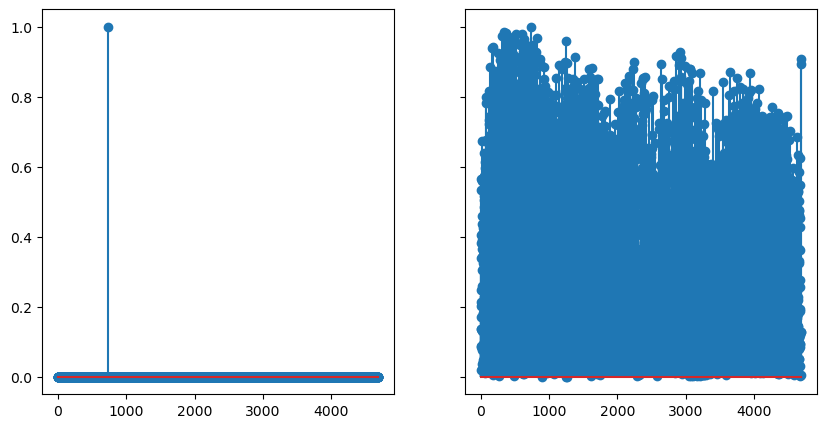

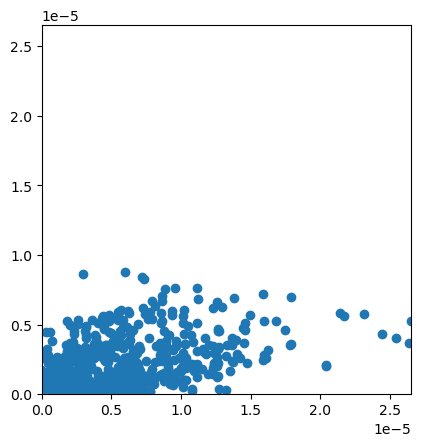

In [6]:
import matplotlib.pyplot as plt
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

ax1.stem(x.std(1) / x.std(1).max())
ax2.stem(x_hat.std(1) / x_hat.std(1).max())

y_hat = L @ x_hat

plt.figure()
plt.scatter(y.ravel(), y_hat.ravel())
plt.axis('square')
plt.xlim(0, y.ravel().max())
plt.ylim(0, y.ravel().max())

In [7]:
from bsi_zoo.metrics import reconstructed_noise

print('Recontructed noise:', reconstructed_noise(x, x_hat, subject='CC120166', orientation_type=orientation_type, nnz=nnz, y=y, L=L))

Recontructed noise: 0.7790723527470969
